In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

from skimage.data import imread
from skimage.io import imshow
from skimage.feature import corner_harris, corner_peaks

from scipy.signal import gaussian
from scipy.signal import convolve2d

In [394]:
# Constants :
kappa = 0.05
sigma_d = 1
sigma_i = 2
local = 1 # Local window for local minima
threshold = 0.1
c = 0.9
top = 300

# Theoritical results

   ## chesboard

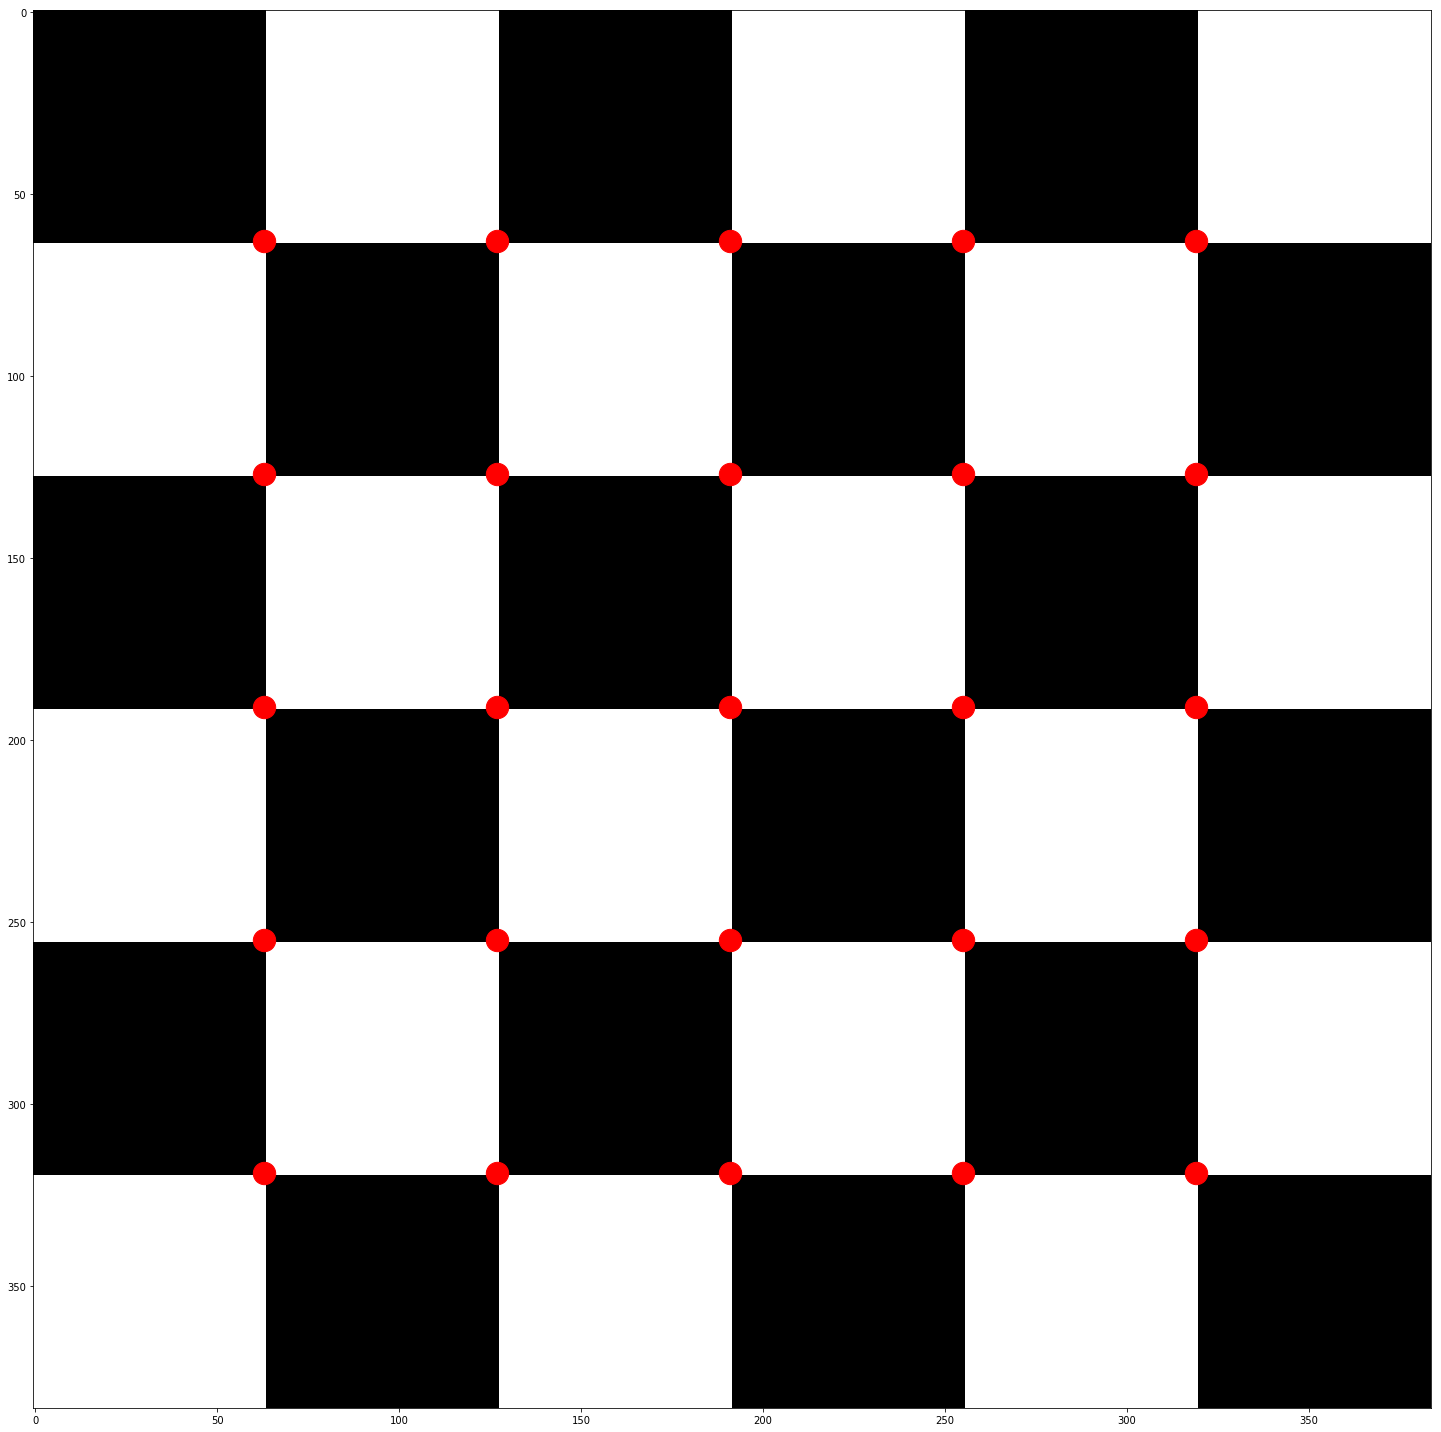

In [395]:
chessboard = imread('images/checkerboard.png')
chess_th = corner_peaks(corner_harris(chessboard), min_distance = 5);
plt.figure(figsize = (20, 20));
plt.scatter(chess_th[:, 0], chess_th[:, 1], color = 'r', marker= ".", s = 2000);
imshow(chessboard);

## bouc.pgm

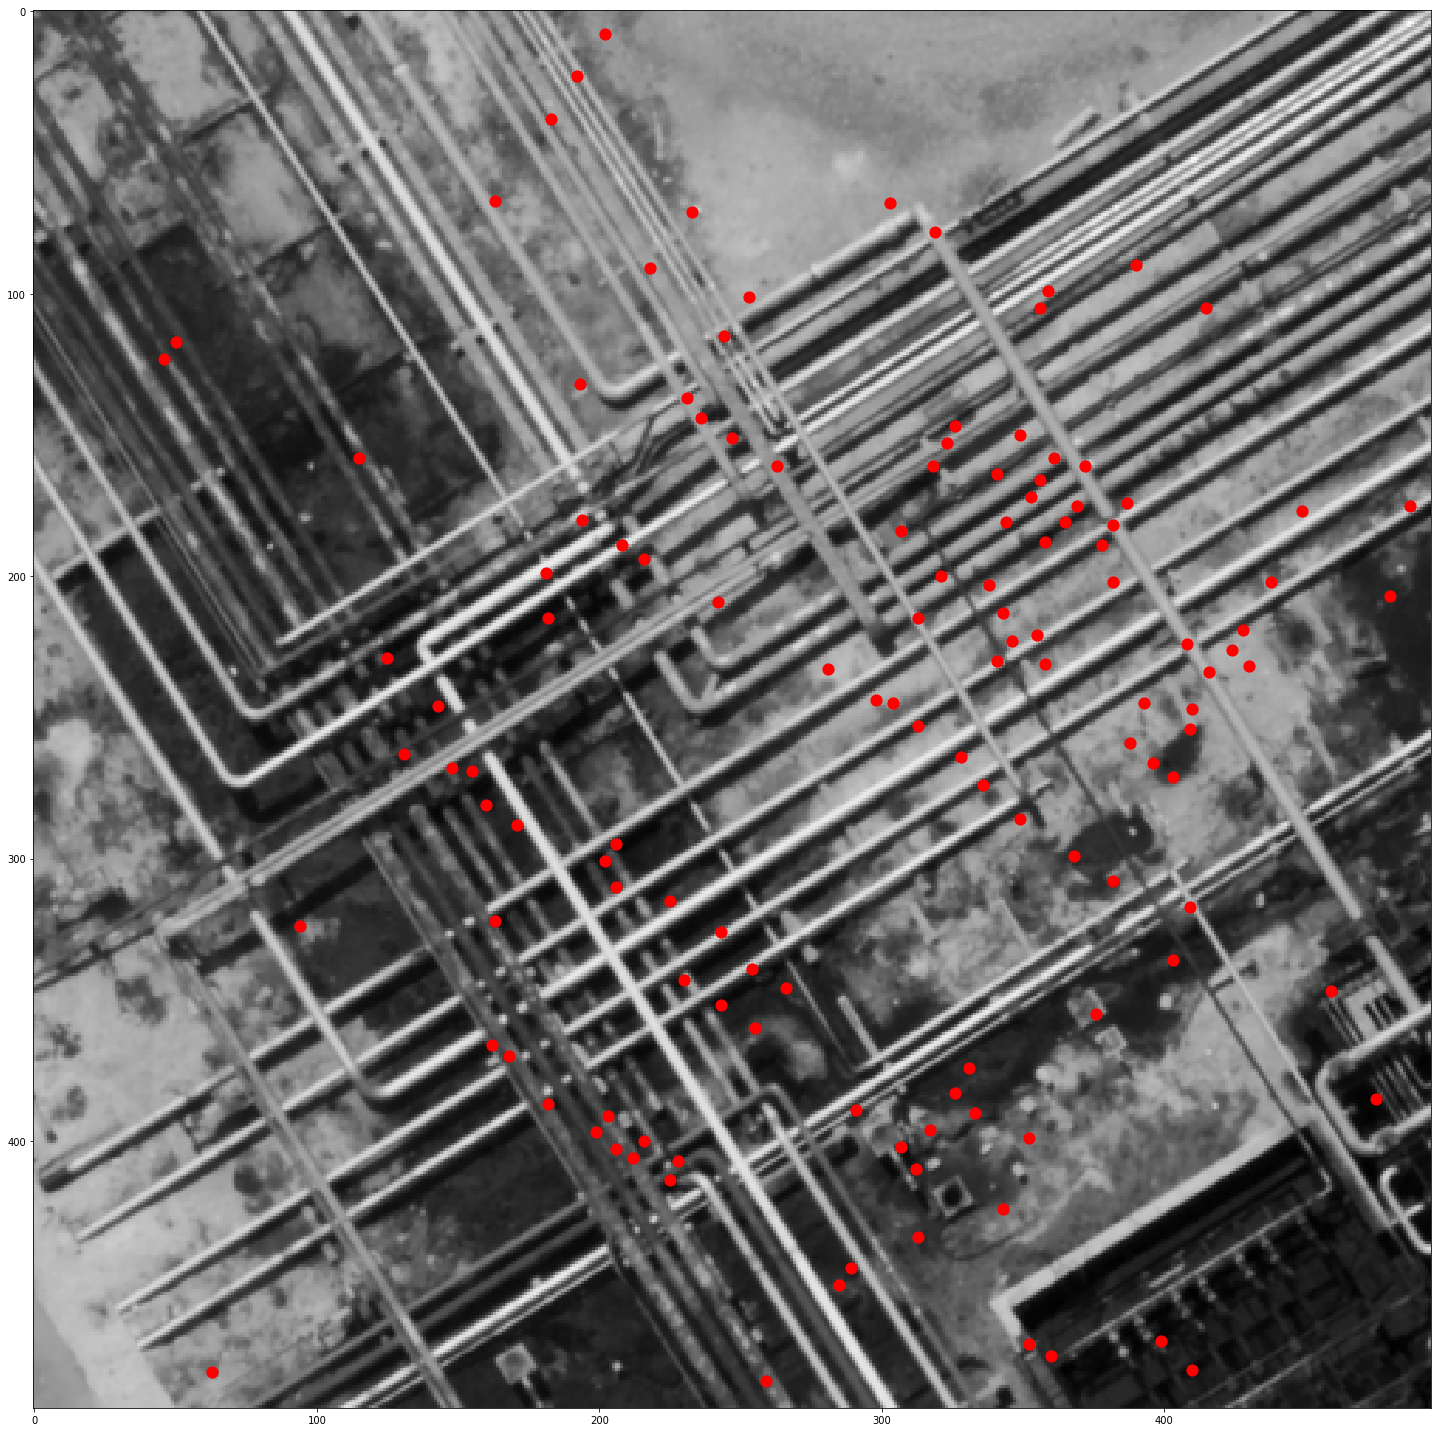

In [396]:
bouc = imread('images/bouc.pgm')
theorical = corner_peaks(corner_harris(bouc), min_distance = 5);
plt.figure(figsize = (20, 20));
plt.scatter(theorical[:, 0], theorical[:, 1], color = 'r', marker= ".", s = 500);
imshow(bouc);

# Practical session

In [397]:
theorical.shape

(130, 2)

In [398]:
# bouc = chessboard

In [399]:
# Size of image
bouc.shape

(495, 495)

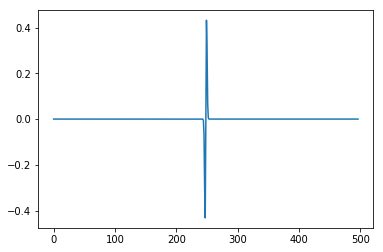

In [400]:
dx = [-0.5, 0, 0.5]

G = np.convolve(gaussian(bouc.shape[0], std = sigma_d), dx);
plt.plot(G);

In [401]:
Gx = G.reshape(1, -1)
Gy = Gx.T
Gxy = Gy.dot(Gx)

print ("Shape of Gx : {} and Gy : {}".format(Gx.shape, Gy.shape))

Shape of Gx : (1, 497) and Gy : (497, 1)


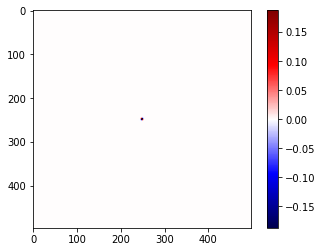

In [402]:
plt.imshow(Gxy, cmap = 'seismic');
plt.colorbar();

In [403]:
Ix = convolve2d(bouc, Gx, mode = 'same')
Iy = convolve2d(bouc, Gy, mode = 'same')

In [404]:
print ("Shape of Ix : {} and Iy : {}".format(Ix.shape, Iy.shape))

Shape of Ix : (495, 495) and Iy : (495, 495)


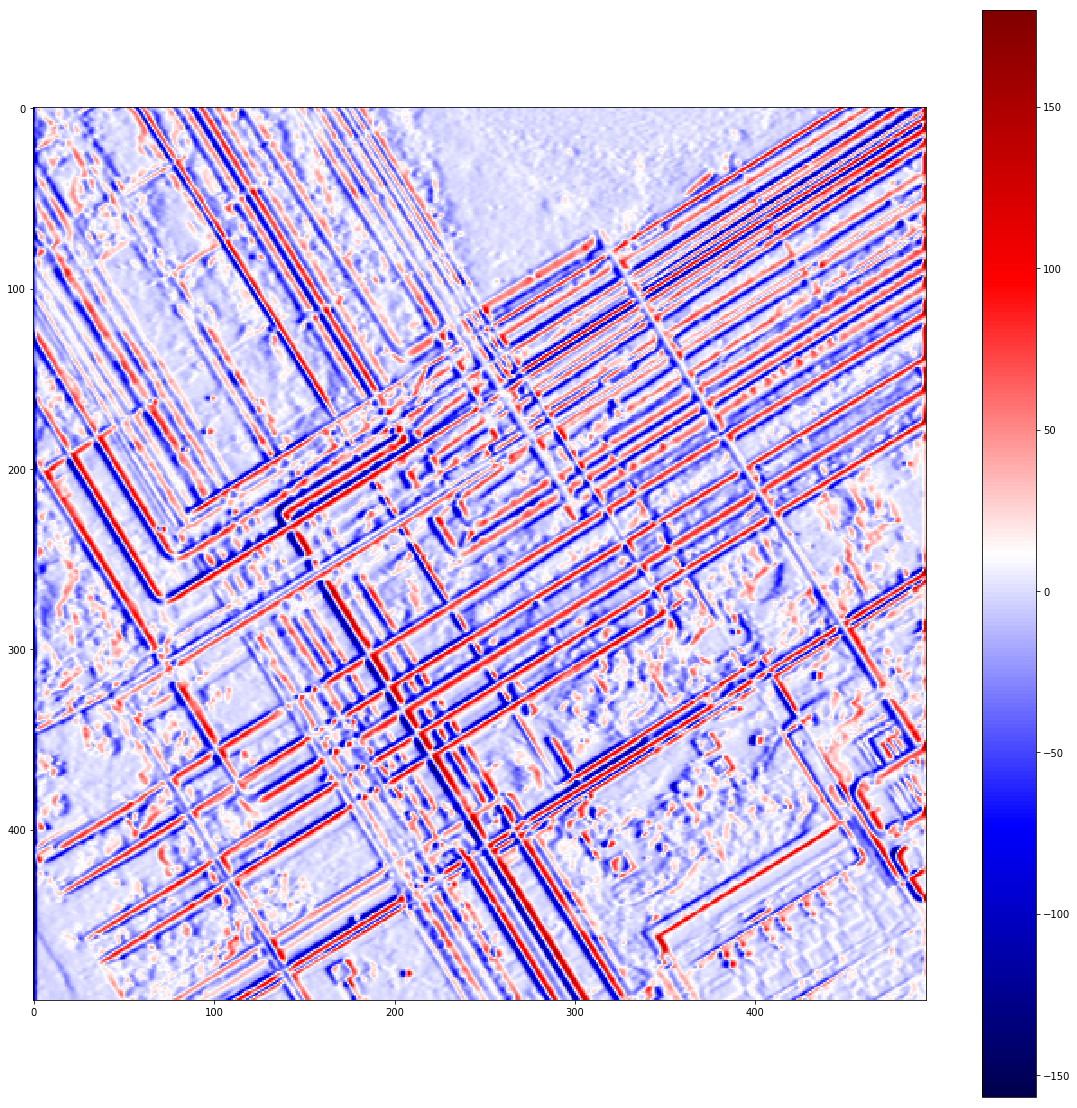

In [405]:
plt.figure(figsize = (20, 20));
plt.imshow(Ix, cmap = "seismic"); plt.colorbar();

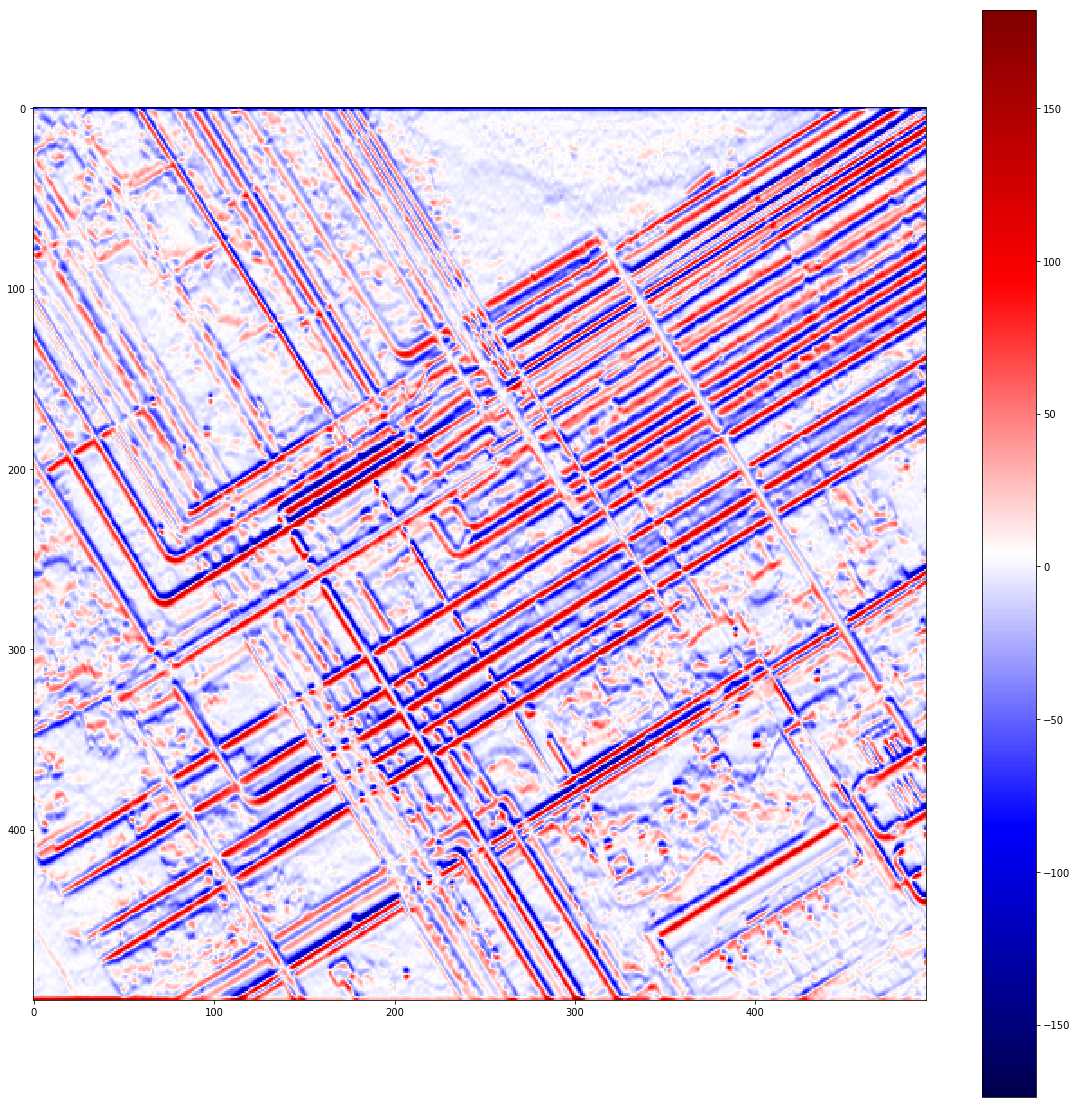

In [406]:
plt.figure(figsize = (20, 20));
plt.imshow(Iy, cmap = "seismic"); plt.colorbar();

# Product images

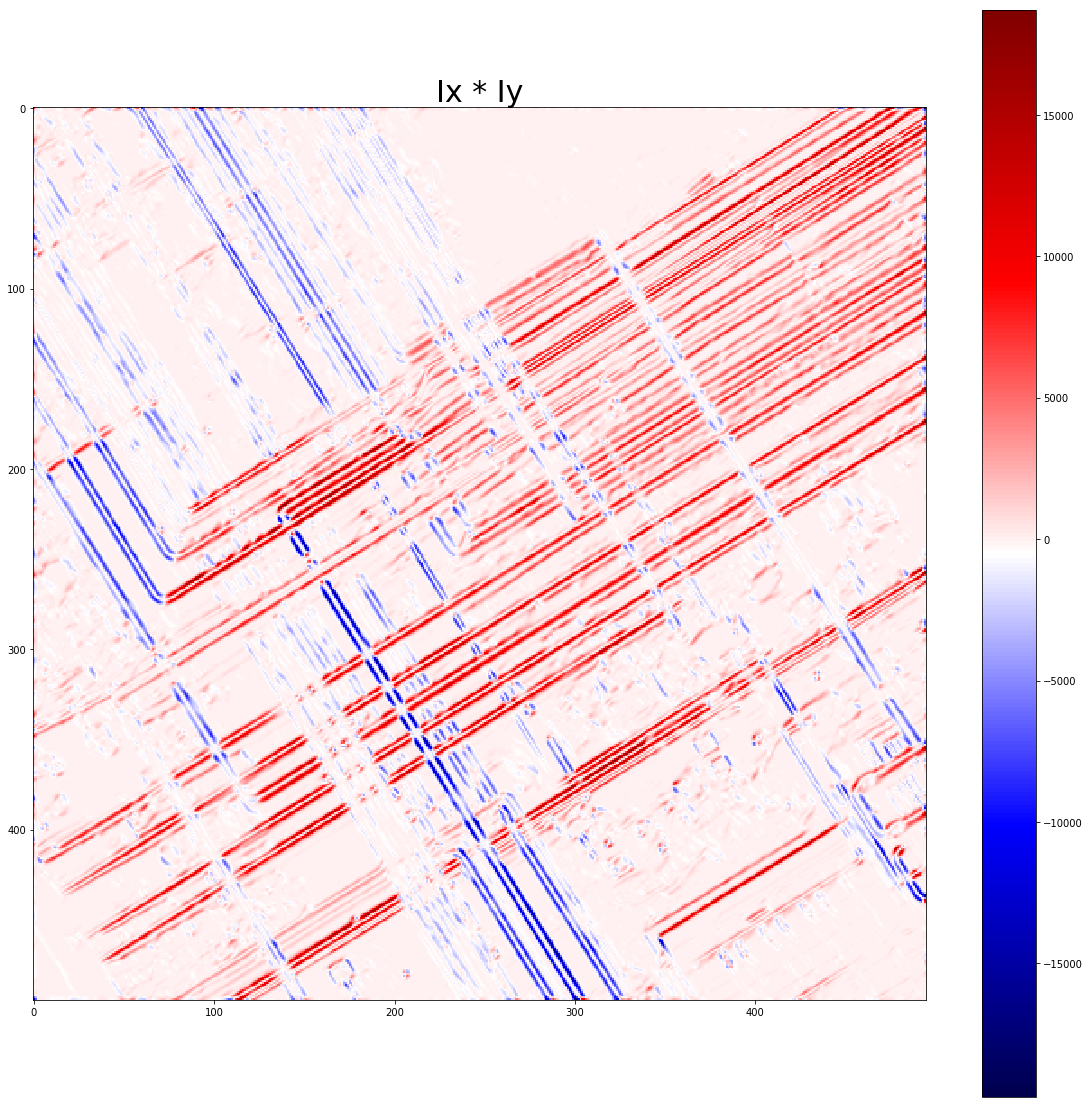

In [407]:
plt.figure(figsize = (20, 20));
plt.imshow(Ix * Iy, cmap = "seismic"); plt.colorbar();
plt.title("Ix * Iy", fontsize = 30);

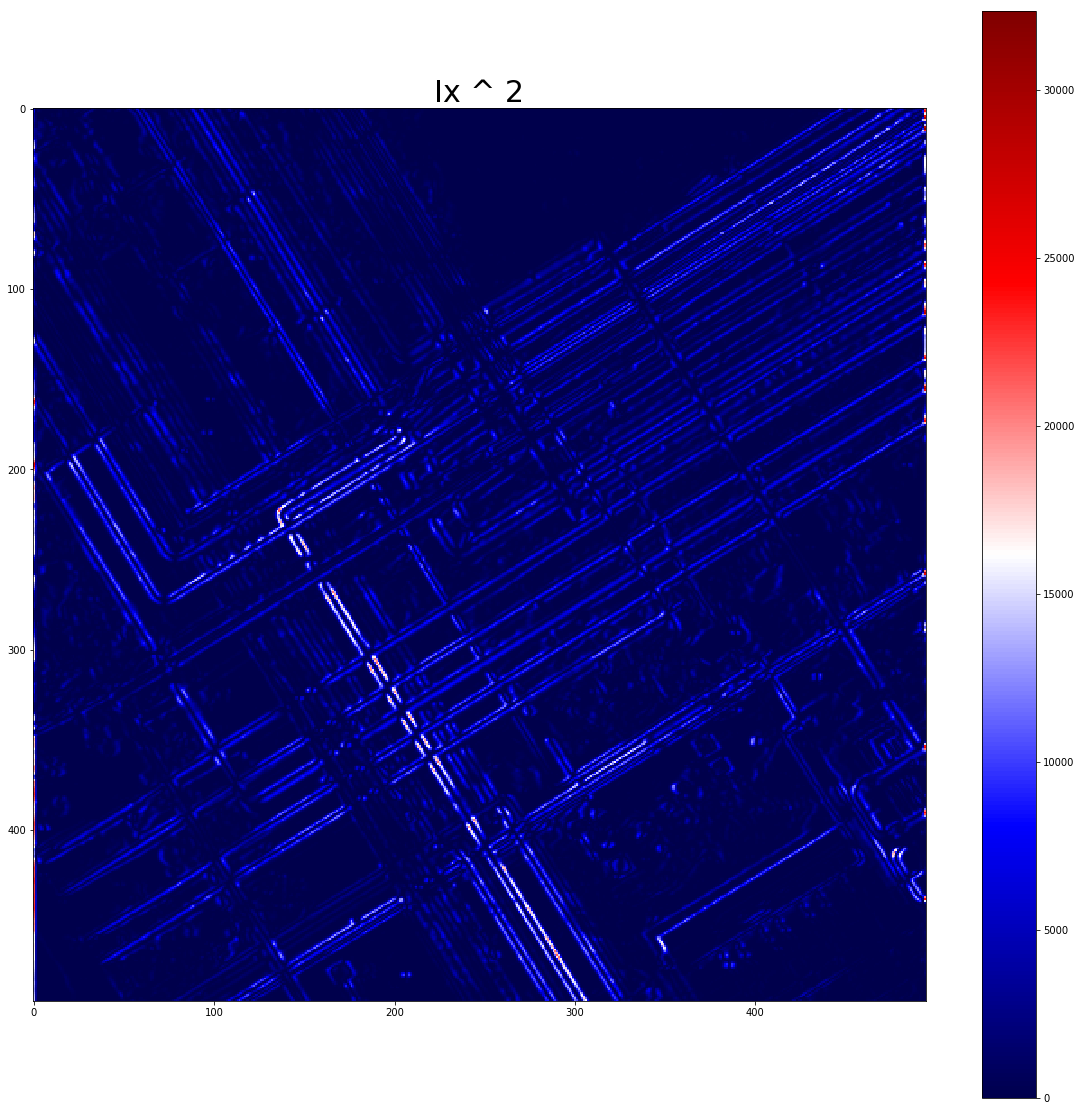

In [408]:
plt.figure(figsize = (20, 20));
plt.imshow(Ix ** 2, cmap = "seismic"); plt.colorbar();
plt.title("Ix ^ 2", fontsize = 30);

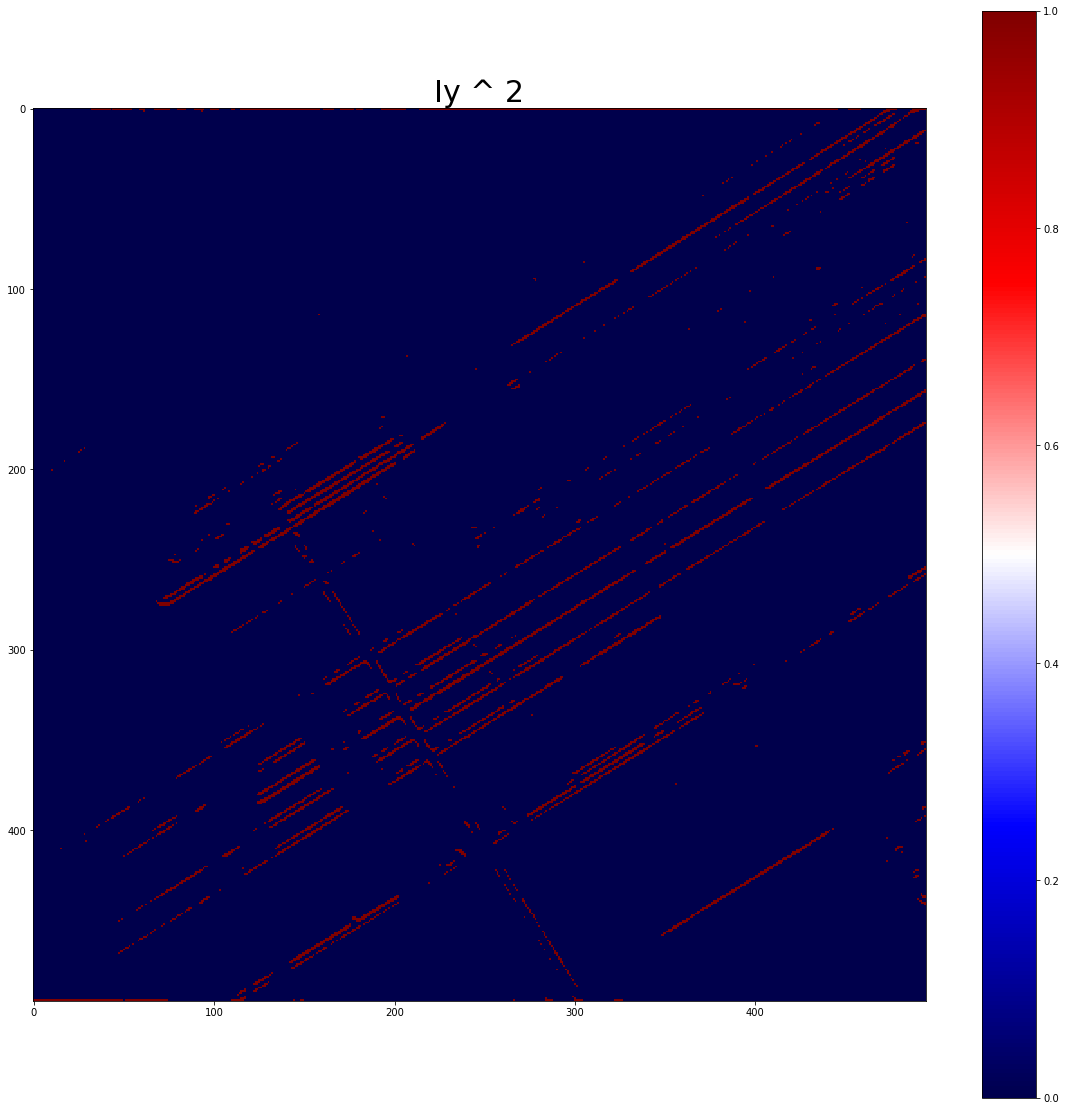

In [409]:
plt.figure(figsize = (20, 20));
plt.imshow(Iy ** 2 > 10000, cmap = "seismic"); plt.colorbar();
plt.title("Iy ^ 2", fontsize = 30);

In [410]:
# Add extra smoothing function
smooth_x = gaussian(bouc.shape[0], std = sigma_i).reshape(1 , -1)
smooth_y = smooth_x.T

smooth_xy = smooth_y.dot(smooth_x)

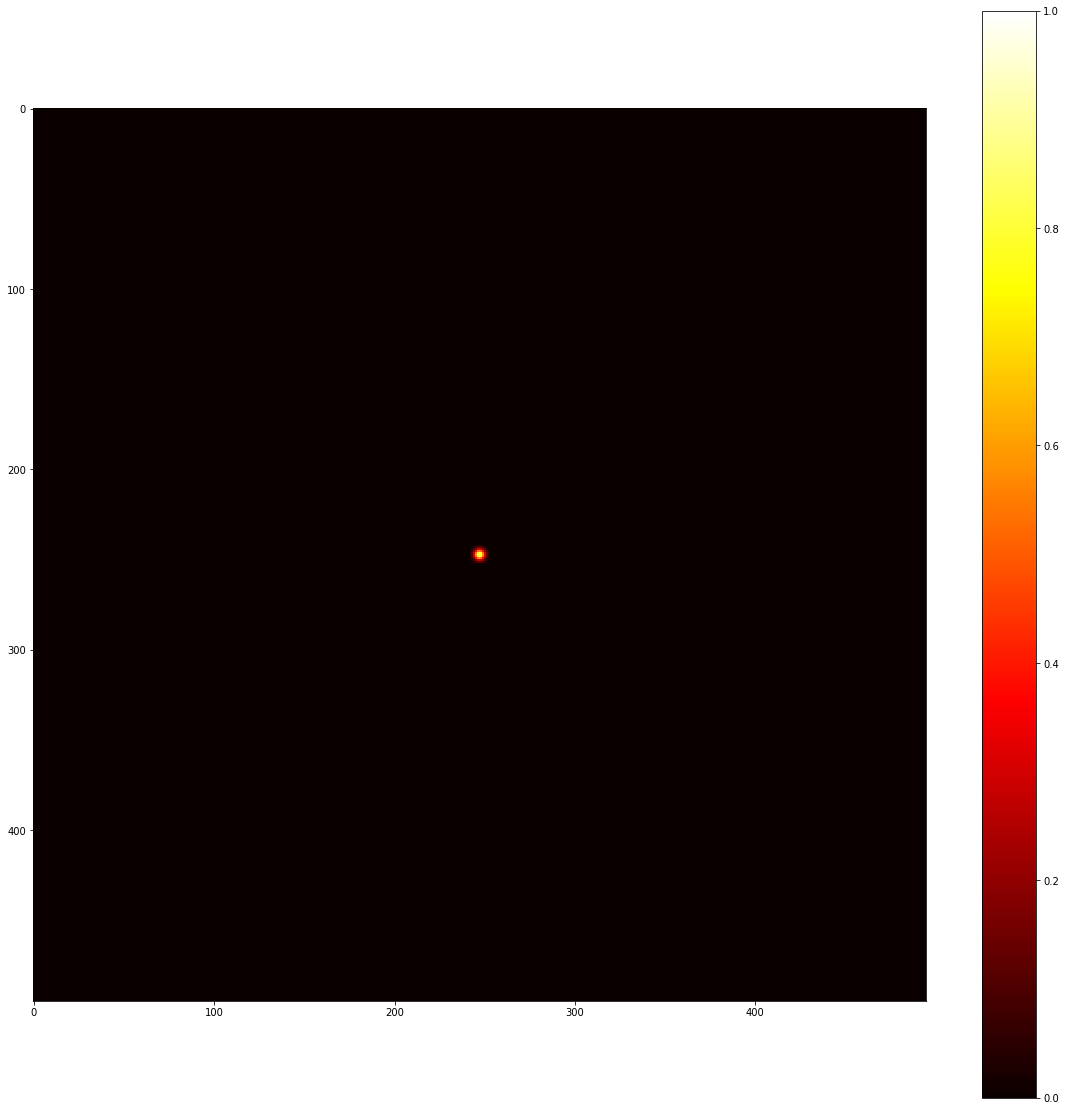

In [411]:
plt.figure(figsize = (20, 20))
plt.imshow(smooth_xy, cmap = "hot") ; plt.colorbar();

In [412]:
# 2 Convolutions 1D with smooth x and smooth y after
Ixy = Ix * Iy;
Ixy_smooth = convolve2d(convolve2d(Ixy, smooth_x, mode = "same"), smooth_y, mode = "same");
Iy_smooth = convolve2d(convolve2d(Iy, smooth_x, mode = "same"), smooth_y, mode = "same")
Ix_smooth = convolve2d(convolve2d(Ix, smooth_x, mode = "same"), smooth_y, mode = "same")

# Auto-correlation matrix

In [413]:
A = np.array([[Ix_smooth**2, Ixy_smooth], [Ixy_smooth, Iy_smooth**2]])
A.shape

(2, 2, 495, 495)

In [414]:
B = A[:, :, 100, 100];
B

array([[ 1468.97546981,  -128.98226376],
       [ -128.98226376,   668.25931805]])

In [415]:
Mc = np.linalg.det(B) - 0.04 * np.trace(B) ** 2
Mc

782309.21978407737

In [416]:
np.linalg.eigvals(B)

array([ 1489.23956796,   647.9952199 ])

In [417]:
C = A[:, :, 137, 222];
print (C)
np.linalg.eigvals(C)

[[ 119217.81327569   30658.15127834]
 [  30658.15127834  628622.93891744]]


array([ 117379.31165009,  630461.44054304])

In [418]:
np.linalg.det(A.T)[100, 100]

965020.12132160773

In [419]:
np.linalg.eigvals(A).shape

(2, 2, 495)

In [420]:
D = A.copy()

In [421]:
Corner_response_eigs = np.linalg.eigvals(D.T)
Corner_response_Mc = np.linalg.det(D.T) - kappa * np.trace(D.T, axis1 = 2, axis2 = 3)**2
Corner_response_Mc = Corner_response_Mc.T 
print ("Shape of corner response : {}".format(Corner_response_Mc.shape))

Shape of corner response : (495, 495)


In [422]:
# Reponse above threshold and local maximum (8 neighbors) => detection
## Reponses below threshold * max are set to 0
Corner_response_Mc[Corner_response_Mc < threshold * Corner_response_Mc.max()] = 0
## Keep local maxima (in 3x3)
h, w = Corner_response_Mc.shape
detected_points = Corner_response_Mc.copy()
for i,j in np.ndindex(detected_points.shape):
    local_max = Corner_response_Mc[max(0, i - local):min(i + local + 1, h),
                                   max(0, j - local):min(j + local + 1, w)].max()
    if detected_points[i, j] == local_max:
        detected_points[max(0, i - local):min(i + local + 1, h),
                        max(0, j - local):min(j + local, w)].fill(0)
        detected_points[i, j] = local_max
    else:
        detected_points[i, j] = 0

In [423]:
print ("Total of detected points after thresholding : {}".format((Corner_response_Mc > 0).sum()))
print ("Total of detected points after local maxima cut : {}".format((detected_points > 0).sum()))

Total of detected points after thresholding : 13615
Total of detected points after local maxima cut : 1392


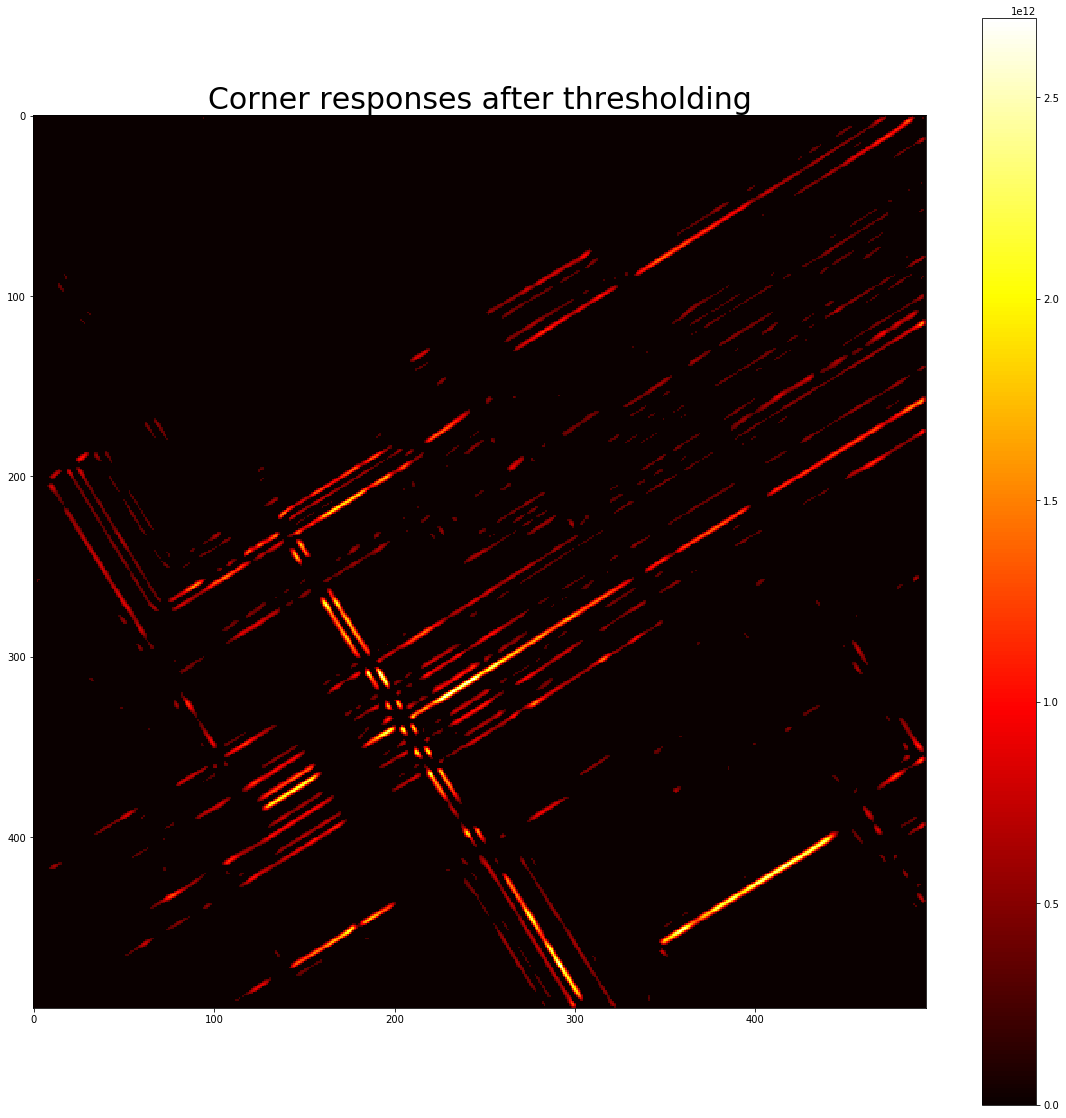

In [424]:
plt.figure(figsize = (20, 20));
plt.imshow(Corner_response_Mc, cmap = "hot") ; plt.colorbar();
plt.title("Corner responses after thresholding", fontsize = 30);

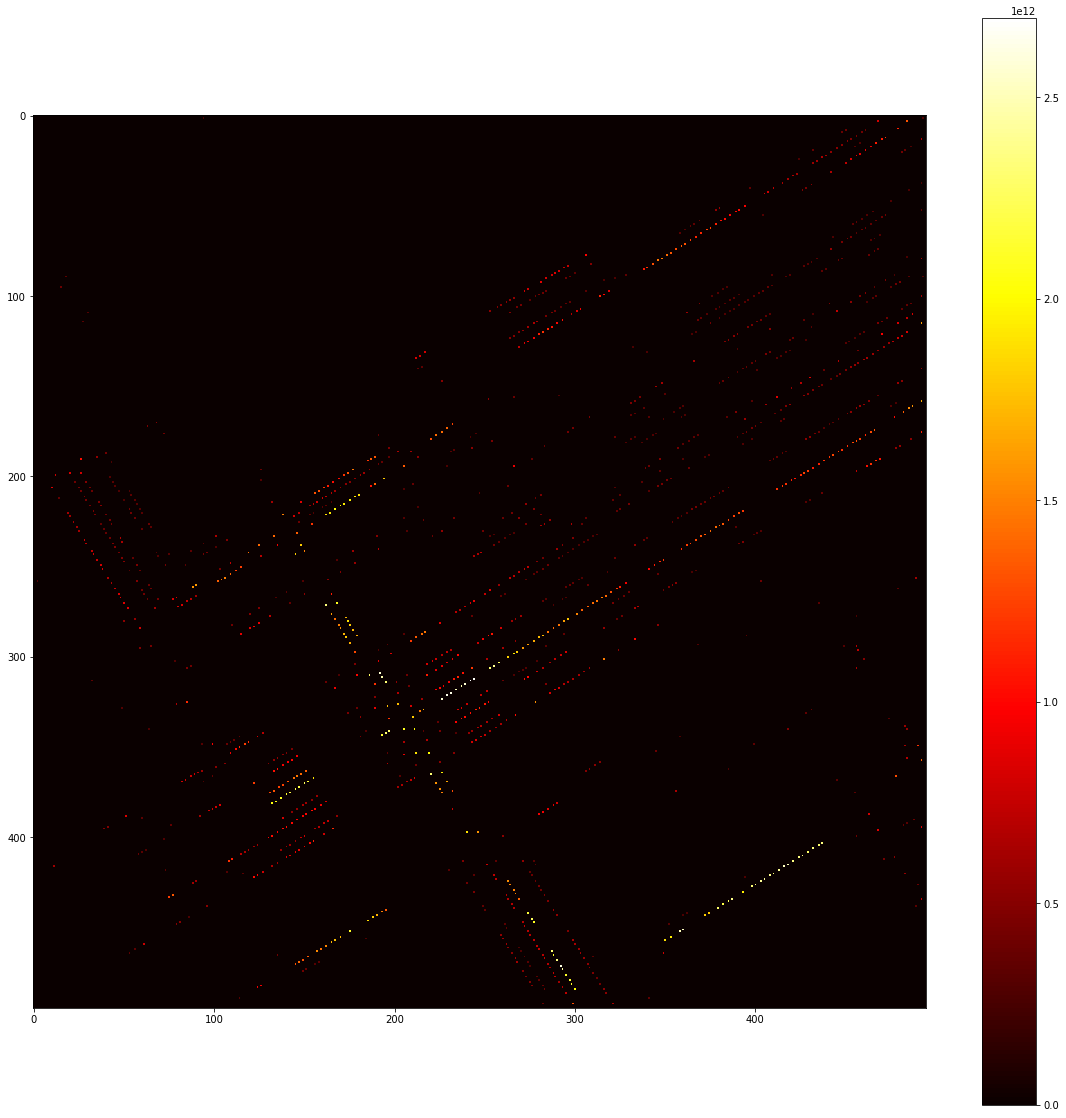

In [425]:
plt.figure(figsize = (20, 20));
plt.imshow(detected_points, cmap = "hot") ; plt.colorbar();
# plt.scatter(chess_th[:, 0], chess_th[:, 1], color = 'white', marker= ".", s = 20);

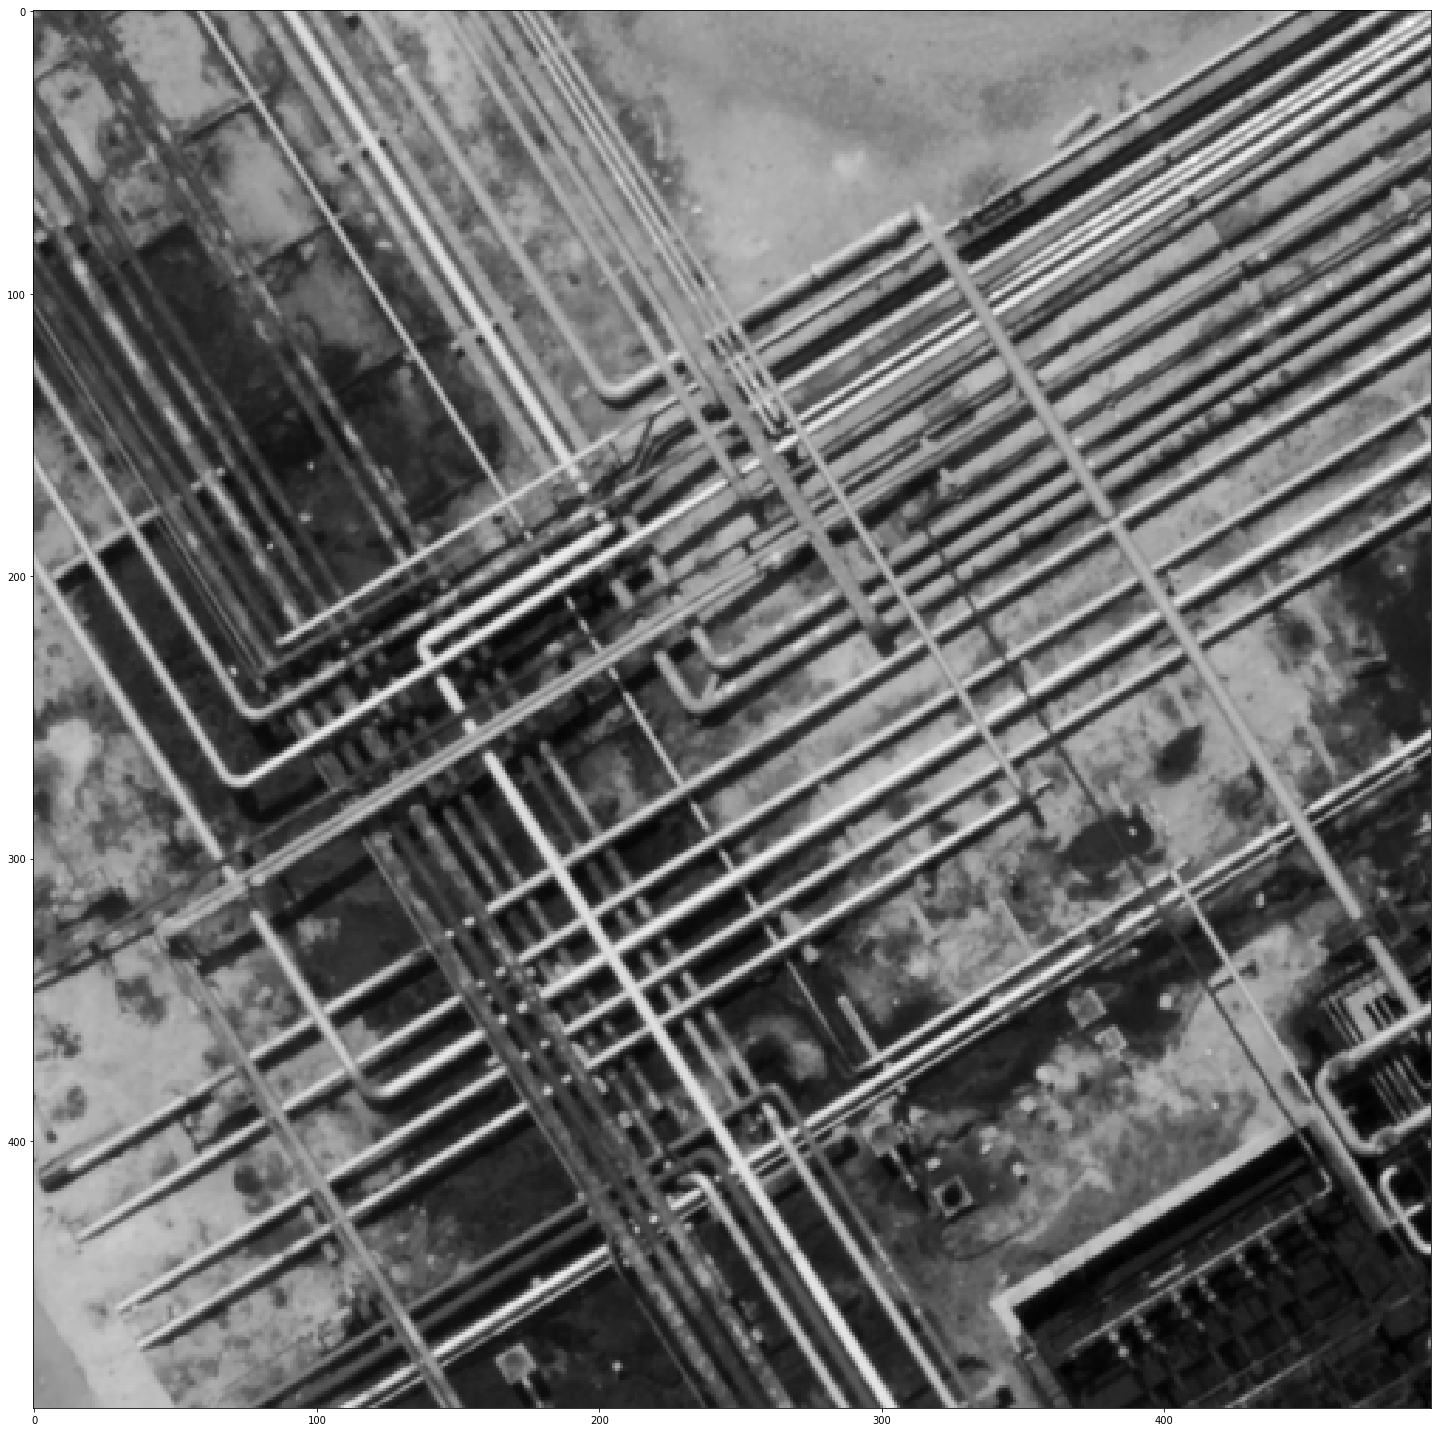

In [426]:
plt.figure(figsize = (20, 20));
imshow(bouc);

# Adaptative non-maximum suppression

In [427]:
list(np.argwhere(detected_points == detected_points.max())[0])

[313, 242]

In [428]:
d = np.ndenumerate(detected_points)
detected = []
for i,j in d:
    detected.append((i[0], i[1], j))
detected = np.array(detected)

In [429]:
detected_points[np.argwhere(detected_points == detected_points.max())]

array([[[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   3.40757523e+11,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.000000

In [430]:
p = detected[:, 2]
p.sort()

In [431]:
p

array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
         2.63804020e+12,   2.67109108e+12,   2.69774758e+12])

## Algo 

In [432]:
len(detected_points)

495

In [433]:
D = detected_points.copy()
r = np.inf

# Processed Points
P = np.argwhere(D == D.max())[0].reshape(1, -1)

# Value
F = D.max()

# Remove P from D
D[P[-1]] = 0

# Radius
R = [np.inf]

In [434]:
m = D.max()
while (m > 0):
    p = np.argwhere(D == m)[0].reshape(1, -1)
    q = P[(c * F > m)[:, 0]] if (c * F > m).sum() else []
    r = np.linalg.norm(np.repeat(p, len(q), axis = 0) - q, axis = 1).min() if len(q) > 0 else 0
    R.append(r)
    P = np.vstack((P, p))
    D[P[-1][0], P[-1][1]] = 0
    F = np.vstack((F, m))
    m = D.max()

In [435]:
len(P)

1384

In [436]:
len(R)

1384

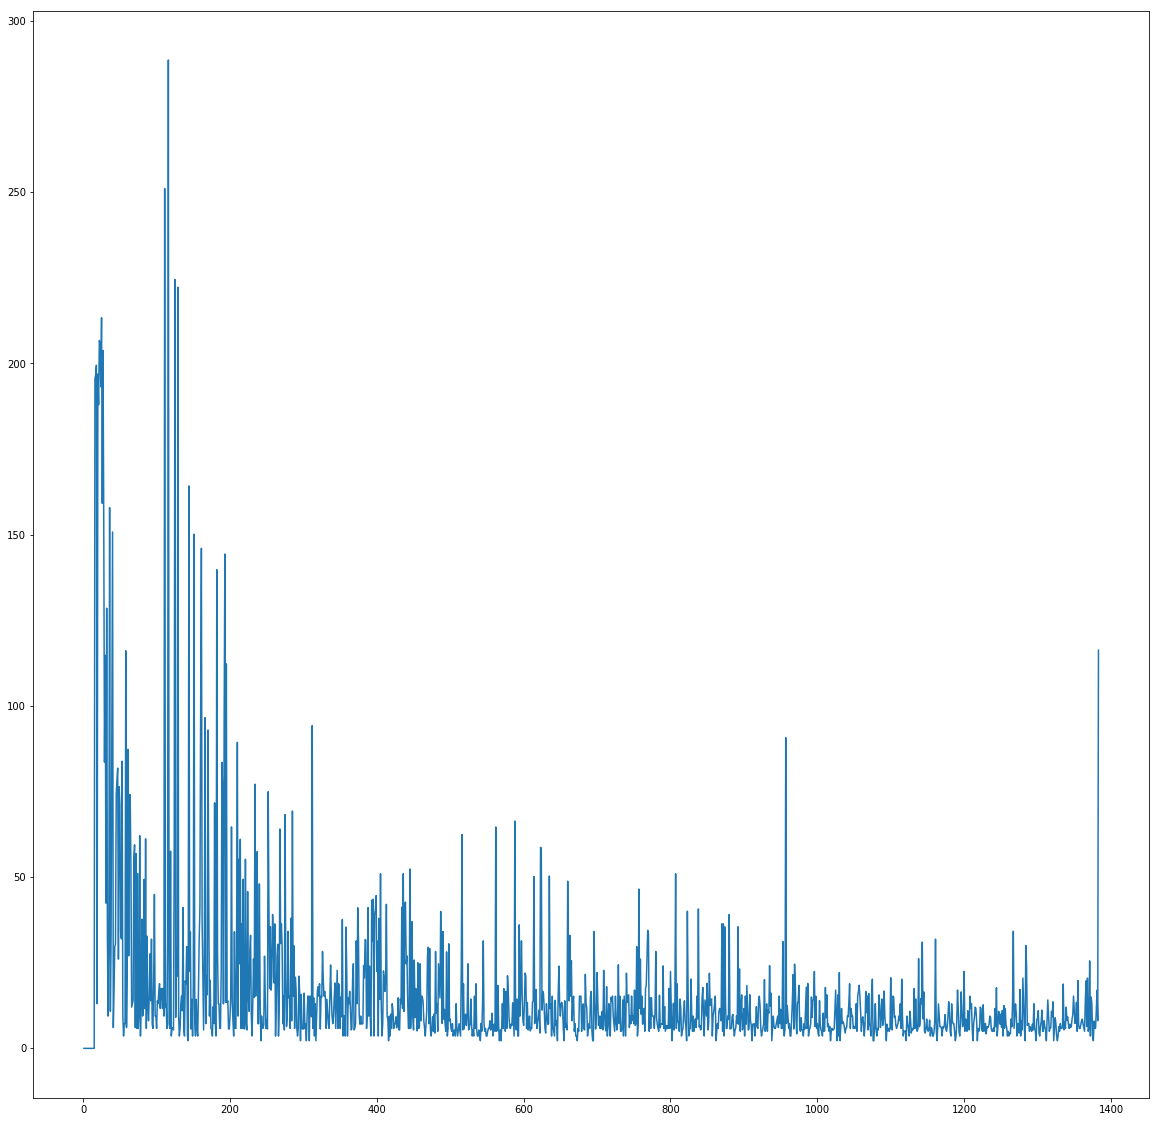

In [437]:
plt.figure(figsize = (20, 20));
plt.plot(R);

In [438]:
# Get the first points associated with top radius
top_scoring = P[np.argsort(R) < top]

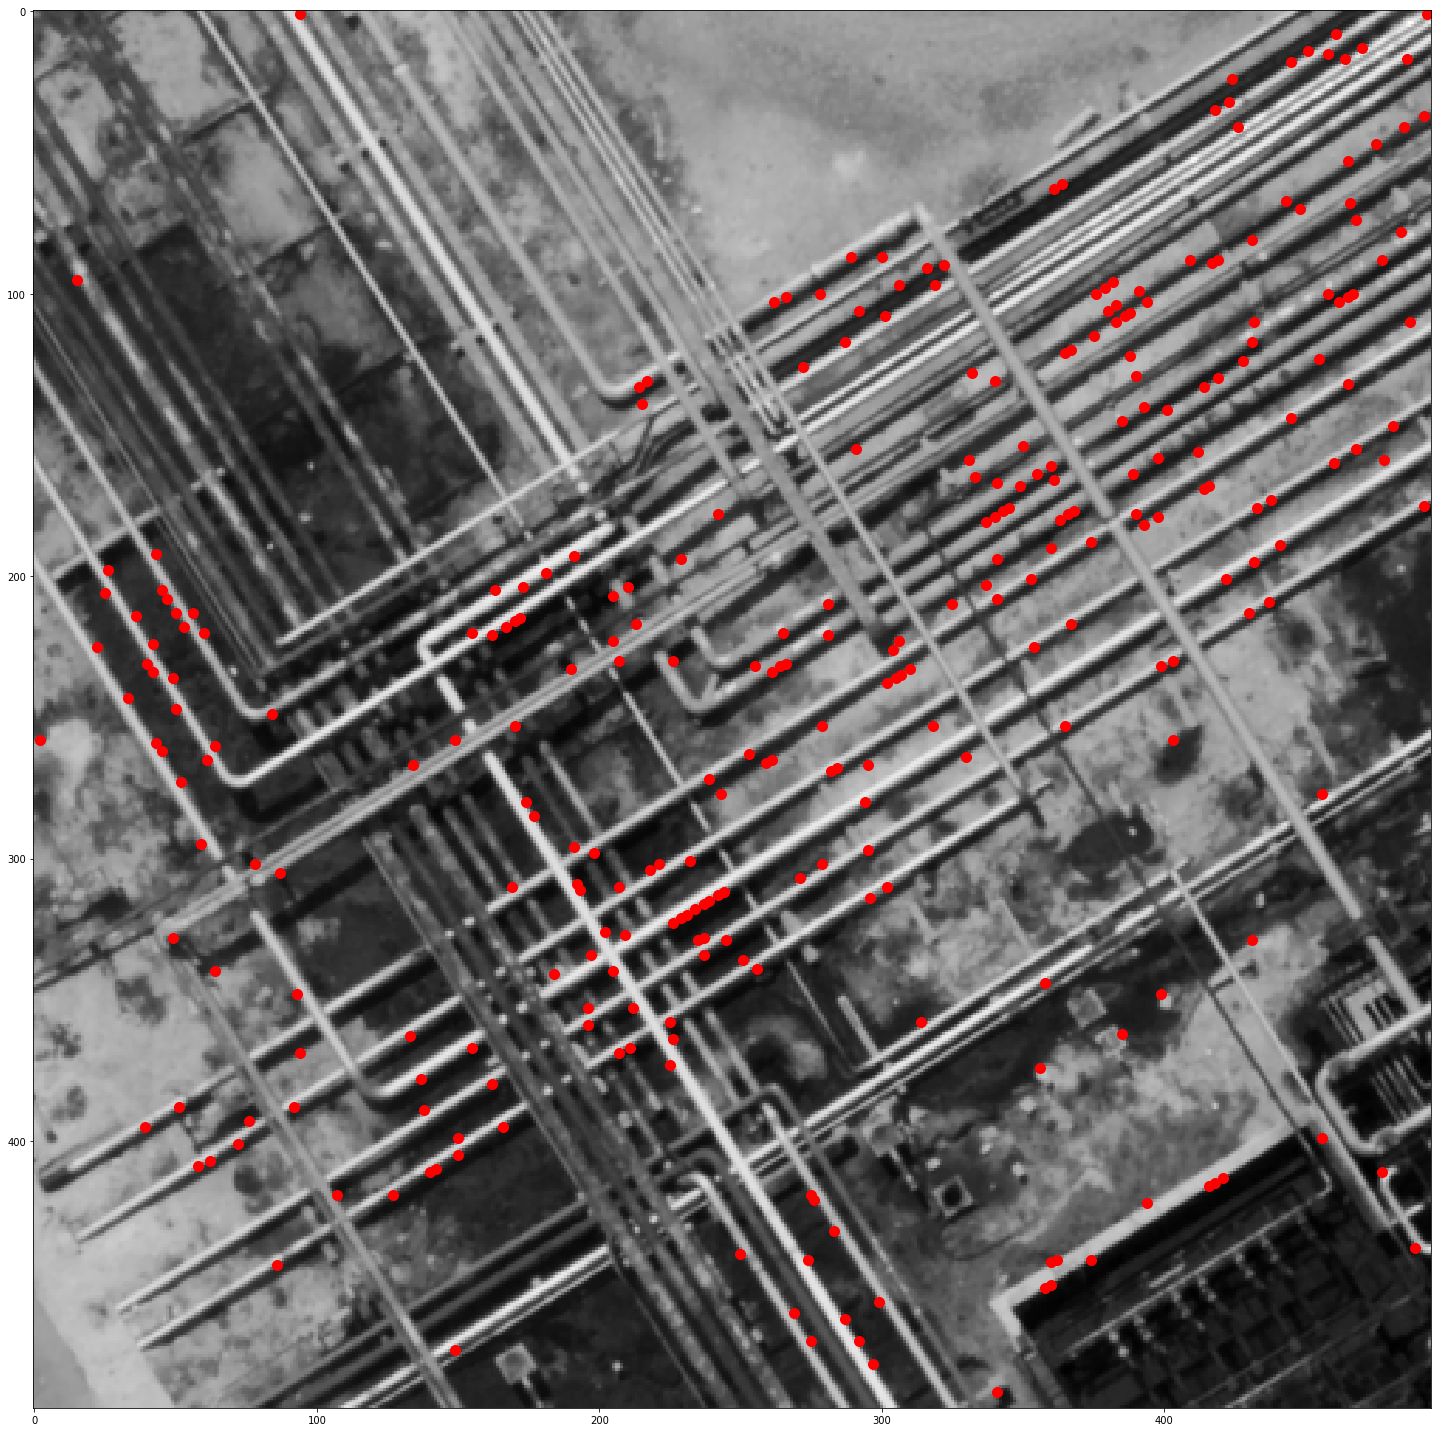

In [439]:
plt.figure(figsize = (20, 20));
plt.scatter(top_scoring[:, 1], top_scoring[:, 0], color = 'red', s = 100)
imshow(bouc);